In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import TensorBoard

In [2]:
import sys
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
def write_log(callback, names, logs, batch_no):
    for name, value in zip(names, logs):
        summary = tf.Summary()
        summary_value = summary.value.add()
        summary_value.simple_value = value
        summary_value.tag = name
        callback.writer.add_summary(summary, batch_no)
        callback.writer.flush()

def tf_summary_image(image):
    size = image.get_size_inches()*image.dpi # imageはMatplotlibのFigure形式
    height = int(size[0])
    width = int(size[1])
    channel= 1
    with io.BytesIO() as output:
        image.savefig(output, format="PNG")
        image_string = output.getvalue()
    return tf.Summary.Image(height=height,
                            width=width,
                            colorspace=channel,
                            encoded_image_string=image_string)
    
def write_img(callback, name, image, batch_no):
    tf_image = tf_summary_image(image)
    summary = tf.Summary(value=[tf.Summary.Value(tag=name, image=tf_image)])
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

In [4]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100 # Noiseの次元を決めている。
        optimizer = Adam(0.0002, 0.5)
        
        KTF.set_learning_phase(1) # Tensorboard用。learning_phaseはTrainingとTestで動作が異なる場合に使用。

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True       
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)
        
        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
              
        # functional APIの使い方
        # validity = self.discriminator(img) <- img = self.generator(z) <- z
        # cf. https://qiita.com/Mco7777/items/1339d01bc6ef028e7b44
        # my_dense = Dense(5)
        # model_input = Input(shape=(5,))
        # mid = my_dense(model_input)
        # mid2 = my_dense(mid)
        # output = Activation('softmax')(mid2)
        # model = Model(inputs=model_input, outputs=output)
        # つまり、ここのModelはbuild_generator、build_discriminatorのModelとは別。
        # function APIを使わない方法は以下を参照。
        # https://qiita.com/triwave33/items/1890ccc71fab6cbca87e

        # For the combined model we will only train the generator
        # <plan_A>
        self.discriminator.trainable = False
        # <plan_B layer.nameは都度変わるので名前での指定はできなかった。>
        # count = 0
        # for layer in self.combined.layers:
        #     if count == 2:
        #         layer.trainable = False
        #     count += 1
        
        # Model#compile() は、呼び出されると内包しているLayer全てからtrainable_weights
        # を回収する動きをするため、compile()前のtrainableの指定が有効とのことから、
        # plan_Aで、combined modelだけtrainable=Falseにできると考えられる。
        # https://qiita.com/mokemokechicken/items/937a82cfdc31e9a6ca12
        # しかし、discriminatorのsummary()のパラメーターが2倍になってしまう。
        # Plan_AでもPlan_Bも同様。
        # 12-14行目を62行目以降に持って方法では、combinedのNon-trainがおかしくなる。
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(100, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(300))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(900))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Reshape((30, 30, -1)))
        model.add(Conv2D(16, (2, 2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(MaxPooling2D((2, 2), strides=1, padding='same'))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Reshape((58, 58, -1)))
        model.add(Conv2D(128, (3, 3)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dense(1, activation='tanh')) # activation='tanh'なので-1,1の範囲の値を持つ。
        # model.add(Reshape(self.img_shape))
        # model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        # model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):
        log_path = './my_log_dir'
        callback = TensorBoard(log_dir='./my_log_dir')
        callback.set_model(self.combined)
        train_names = ['d_loss', 'd_acc']
        val_names = ['g_loss', 'g_acc']
        
        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3) # Insert a new axis.

        # Adversarial ground truths
        valid_1 = np.ones((batch_size, 1))
        fake_0 = np.zeros((batch_size, 1))
        valid = (1.2 - 0.7) * np.random.rand(batch_size, 1) + 0.7
        fake = (0.3 - 0.0) * np.random.rand(batch_size, 1) + 0.0
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid) # 単一バッチデータにつき一度の勾配更新を行う。
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            # train_on_batchは学習の損失を表すスカラ値（モデルが単一の出力を持ち，かつ評価関数がない場合），
            # モデルが複数の出力や評価関数metrics=['accuracy']を持つ場合はスカラ値のリストを戻り値として返す。
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # The arrays to be added. If x1.shape != x2.shape,>-broadcast
            
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid_1)        
            
            # Plot the progress            
            # print ("%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], g_loss[0], 100*g_loss[1]))
            # print ("%d [R_acc: %.2f%%, F_acc.: %.2f%%] [G_acc.: %.2f%%]" % (epoch, 100*d_loss_real[1], 100*d_loss_fake[1], 100*g_loss[1]))
            write_log(callback, train_names, d_loss, epoch)
            write_log(callback, val_names, g_loss, epoch)

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                fig, name = self.sample_images(epoch)
                write_img(callback, name, fig, epoch)
                print ("%d [D loss: %f] [G loss: %f, G acc.: %.2f%%]" % (epoch, d_loss[0], g_loss[0], 100*g_loss[1]))

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        name = str(epoch) + '.png'
        return fig, name
        # fig.savefig("images/%d.png" % epoch)
        # plt.close()

In [5]:
gan = GAN()

0 [D loss: 0.449787] [G loss: 1.331882, G acc.: 28.12%]


KeyboardInterrupt: 

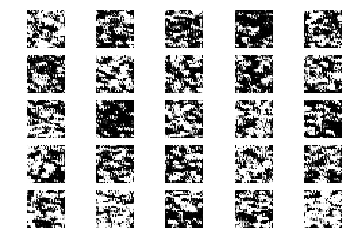

In [7]:
gan.train(epochs=10000, batch_size=32, sample_interval=5000)

In [7]:
gan.generator.save('./saved_model/gan_by_cnn_generator.h5')
gan.discriminator.save('./saved_model/gan_by_cnn_discriminator.h5')
gan.combined.save('./saved_model/gan_by_cnn_combined.h5')
# LeakyReLUを別のLayerにしないとsaveできないよう。

In [ ]:
model.get_weights()

[0.39 0.21 0.25 0.23 0.61 0.47 0.44 0.29 0.41 0.69]


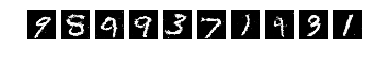

In [8]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100)) # 平均0、標準偏差1の正規分布, shape = (r * c, 100)
noise.shape #generatorに(100,1)を入れたらエラー

gen_imgs_ = gan.generator.predict(noise) # -1,1の値を持つ。
gen_imgs = (0.5 * gen_imgs_ + 0.5) * 1 #0,1にrescale
fig, axs = plt.subplots(1, 10)
for i in range(10):
    axs[i].axis('off')
    axs[i] = axs[i].imshow(gen_imgs[i, :,:,0], cmap='gray')
disc_imgs = gan.discriminator.predict(gen_imgs_)
print(np.round(disc_imgs[0:10], 2).reshape(1,-1)[0])